In [1]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T

<AxesSubplot:>

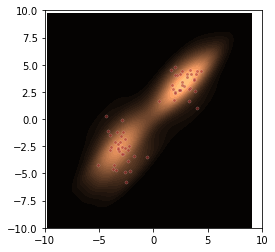

In [2]:
d = 2

dataset = torch.cat([torch.randn(32, d) -3, torch.randn(32, d) + 3])

rng = [-10, 10]

sns.kdeplot(x=dataset[:, 0].numpy(), y=dataset[:, 1].numpy(), fill=True, thresh=0, cmap="copper", levels=32)
plt.xlim(*rng)
plt.ylim(*rng)
plt.gca().set_aspect('equal', adjustable='box')
sns.scatterplot(x=dataset[:, 0], y=dataset[:, 1], s=10, color="brown", alpha=0.5)





In [3]:


import math
from functools import partial

import torch
import torch.nn as nn
from torch.distributions import Transform, constraints

from pyro.nn import DenseNN

from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule


class ShiftScale(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, bound=None):
        super().__init__(cache_size=1)
        self.weights = weights
        self.bias = bias
        self.bound = bound

    def _call(self, x):
        assert len(x.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        b = self.bias() if callable(self.bias) else self.bias
        return a * x + b

    def _inverse(self, y):
        assert len(y.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        b = self.bias() if callable(self.bias) else self.bias
        return (y - b) / a

    def log_abs_det_jacobian(self, x, y):
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        J = a.abs().log()
        assert len(J.shape) == 1
        return J.sum(-1)


class ShiftScaleTransform(ShiftScale, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, bound=None):
        super().__init__(bound=bound)
        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()
        
        
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_dim)
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()






In [4]:
class LowerCholeskyAffine(Transform):
    """
    A bijection of the form,

        :math:`\\mathbf{y} = \\mathbf{L} \\mathbf{x} + \\mathbf{r}`

    where `\\mathbf{L}` is a lower triangular matrix and `\\mathbf{r}` is a vector.

    :param loc: the fixed D-dimensional vector to shift the input by.
    :type loc: torch.tensor
    :param scale_tril: the D x D lower triangular matrix used in the transformation.
    :type scale_tril: torch.tensor

    """
    codomain = constraints.real_vector
    bijective = True
    event_dim = 1
    volume_preserving = False

    def __init__(self):
        super().__init__(cache_size=1)        
        
    def _get_scale_tril(self, input):
        d = self.input_dim
        scale_tril = torch.zeros(d, d, device=input.device)
        scale_tril[self.ix[0], self.ix[1]] = input
        scale_tril[range(d), range(d)] = torch.exp(scale_tril[range(d), range(d)])
        return scale_tril

    
    def _call(self, x):
        assert len(x.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias
        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        return torch.matmul(scale_tril, x.unsqueeze(-1)).squeeze(-1) + loc

    def _inverse(self, y):
        assert len(y.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        
        
        x = torch.linalg.solve_triangular(scale_tril, (y - loc).unsqueeze(-1),
                              upper=False).squeeze(-1)
        
        return x

    def log_abs_det_jacobian(self, x, y):
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias


        scale_tril = self._get_scale_tril(self.weights)
        J = torch.ones(x.size(), dtype=x.dtype, layout=x.layout, device=x.device) * \
            scale_tril.diag().log()
        assert len(J.shape) == 2
        J = J.sum(-1)
        return J
        
class LowerCholeskyAffineModule(LowerCholeskyAffine, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim * (input_dim + 1) // 2))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.ix = torch.tril_indices(input_dim, input_dim)
        self.reset_parameters()

    
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_dim)
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()


    



In [5]:
import math

class ConditionedAffineMatrixExponential(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, iterations=8, normalization="none", bound=None):
        super().__init__(cache_size=1)
        assert iterations > 0
        self.weights = weights
        self.bias = bias
        self.iterations = iterations
        self.normalization = normalization
        self.bound = bound

        # Currently, weight and spectral normalization are unimplemented. This doesn't effect the validity of the
        # bijection, although applying these norms should improve the numerical conditioning of the approximation.
        if normalization == "weight" or normalization == "spectral":
            raise NotImplementedError("Normalization is currently not implemented.")
        elif normalization != "none":
            raise ValueError("Unknown normalization method: {}".format(normalization))

    def _exp(self, x, M):
        
        power_term = x.unsqueeze(-1)
        y = x.unsqueeze(-1)
        for idx in range(self.iterations):
            power_term = torch.matmul(M, power_term) / (idx + 1)
            y = y + power_term

        return y.squeeze(-1)

    def _trace(self, M):
        return M.diagonal(dim1=-2, dim2=-1).sum(-1)

    def _call(self, x):
        assert len(x.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        return self._exp(x, M) + b

    def _inverse(self, y):
        assert len(y.shape) == 2

        b = self.bias() if callable(self.bias) else self.bias
        M = self.weights() if callable(self.weights) else self.weights
        return self._exp(y - b, -M)

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the element-wise determinant of the log Jacobian
        """

        M = self.weights() if callable(self.weights) else self.weights
        return self._trace(M)
    

class AffineMatrixExponentialModule(ConditionedAffineMatrixExponential, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, iterations=8, normalization="none", bound=None):
        super().__init__(
            iterations=iterations, normalization=normalization, bound=bound
        )

        self.weights = nn.Parameter(torch.Tensor(input_dim, input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()



In [6]:

class PositivePowerTransform(Transform):
    r"""
    Transform via the mapping
    :math:`y=\operatorname{sign}(x)|x|^{\text{exponent}}`.

    Whereas :class:`~torch.distributions.transforms.PowerTransform` allows
    arbitrary ``exponent`` and restricts domain and codomain to postive values,
    this class restricts ``exponent > 0`` and allows real domain and codomain.

    .. warning:: The Jacobian is typically zero or infinite at the origin.
    """
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    sign = +1

    def __init__(self, exponent, *, cache_size=0, validate_args=None):
        super().__init__(cache_size=cache_size)
    
    def with_cache(self, cache_size=1):
        if self._cache_size == cache_size:
            return self
        return PositivePowerTransform(self.exponent, cache_size=cache_size)

    def _get_e(self):
#         return F.softplus(self.exponent)
        return self.exponent.exp()

    def _call(self, x):
        assert len(x.shape) == 2
        e = self._get_e()
        return x.abs().pow(e) * x.sign()

    def _inverse(self, y):
        assert len(y.shape) == 2
        e = self._get_e()
        return y.abs().pow(e.reciprocal()) * y.sign()

    def log_abs_det_jacobian(self, x, y):
        e = self._get_e()
        J =  e.log() + (y / x).log()
        assert len(J.shape) == 2
        return J.sum(-1)


    def forward_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    def inverse_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    
class PositivePowerTransformModule(PositivePowerTransform, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__(None)
        self.exponent = nn.Parameter(torch.zeros(input_dim))



In [7]:
base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
num_layers = 4
transform = []
for l in range(num_layers - 1):
#     transform.append(ShiftScaleTransform(d))
#     transform.append(LowerCholeskyAffineModule(d))
    transform.append(AffineMatrixExponentialModule(d))
    transform.append(PositivePowerTransformModule(d))
# transform.append(ShiftScaleTransform(d))
# transform.append(LowerCholeskyAffineModule(d))
transform.append(AffineMatrixExponentialModule(d))


transform_modules = nn.ModuleList([m for m in transform if isinstance(m, nn.Module)])
flow_dist = dist.TransformedDistribution(base_dist, transform)


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(transform_modules)

30

In [9]:
y = flow_dist.sample((4096,))

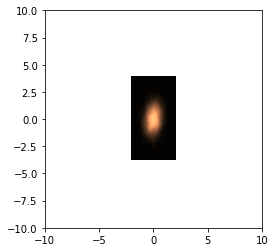

In [10]:
sns.kdeplot(x=y[:, 0].numpy(), y=y[:, 1].numpy(), fill=True, thresh=0, cmap="copper", levels=32)
plt.xlim(*rng)
plt.ylim(*rng)
plt.gca().set_aspect('equal', adjustable='box')



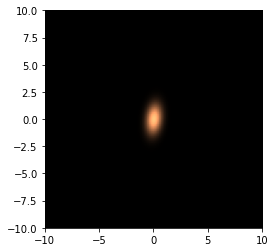

In [11]:
rng = [-10, 10]
num = 128
with torch.no_grad():
    x = torch.linspace(*rng, num)
    x = torch.stack(torch.meshgrid(x, x, indexing='xy'), dim=-1).view(-1, d)

    p = flow_dist.log_prob(x).exp().view(num, num).detach()

    plt.imshow(p.numpy(), cmap='copper', origin='lower', extent=rng+rng)

In [12]:
# matexp = MatrixExponential(d)

In [13]:
from torch.distributions.utils import _sum_rightmost


def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y),  transform
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob
    
log_probs = log_prob(flow_dist, dataset)

AffineMatrixExponentialModule() tensor(0.0212, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(0.0212, grad_fn=<MeanBackward0>)
AffineMatrixExponentialModule() tensor(-0.0880, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(-0.0880, grad_fn=<MeanBackward0>)
AffineMatrixExponentialModule() tensor(0.0671, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(0.0671, grad_fn=<MeanBackward0>)
AffineMatrixExponentialModule() tensor(-0.0144, grad_fn=<MeanBackward0>)


In [14]:
# print(count_parameters(transform_modules))

In [15]:
def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob


step: 0, loss: 25.53995704650879


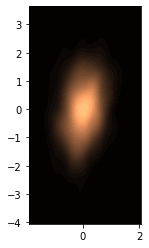

step: 500, loss: 4.906513690948486


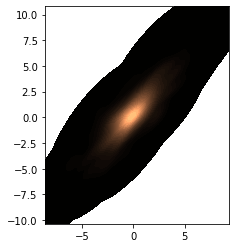

step: 1000, loss: 4.703466415405273


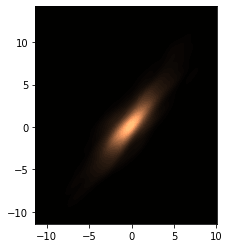

step: 1500, loss: 4.555156230926514


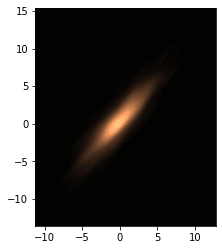

step: 2000, loss: 4.45016622543335


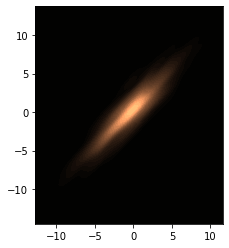

step: 2500, loss: 4.382972717285156


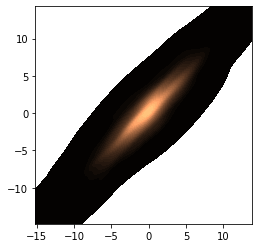

step: 3000, loss: 4.329997539520264


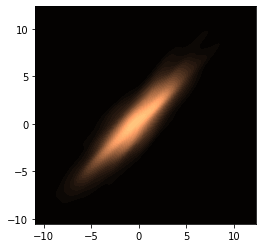

step: 3500, loss: 4.277099609375


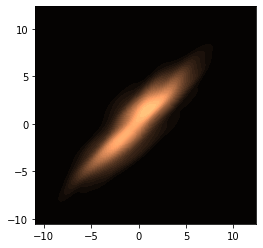

step: 4000, loss: 4.23451042175293


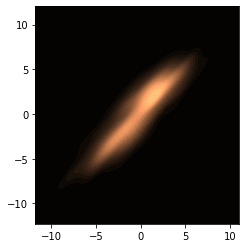

step: 4500, loss: 4.195425033569336


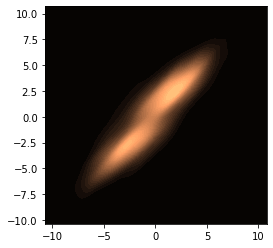

step: 5000, loss: 4.179778099060059


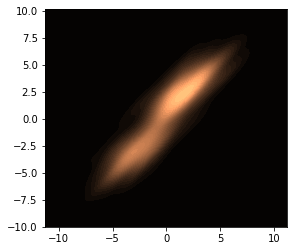

step: 5500, loss: 4.139422416687012


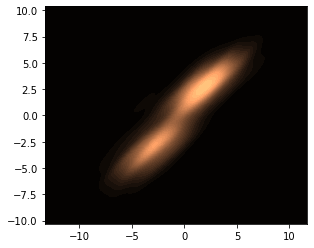

step: 6000, loss: 4.102616310119629


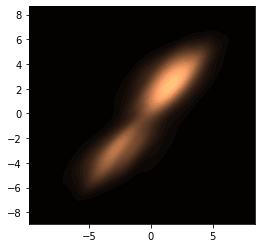

step: 6500, loss: 4.076002597808838


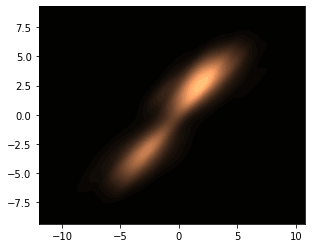

KeyboardInterrupt: 

In [16]:
steps = 32768
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

        sample = flow_dist.sample((1000,)).squeeze().numpy()
        sns.kdeplot(x=sample[:, 0], y=sample[:, 1], fill=True, thresh=0, cmap="copper", levels=32)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

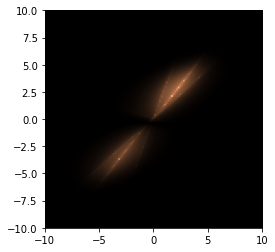

In [17]:
num = 128
with torch.no_grad():
    x = torch.linspace(*rng, num)
    x = torch.stack(torch.meshgrid(x, x, indexing='xy'), dim=-1).view(-1, d)

    p = flow_dist.log_prob(x).exp().view(num, num).detach()

    plt.imshow(p.numpy(), cmap='copper', origin='lower', extent=rng+rng)